## Exploring the faodata package for crop production

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Access the fao data (downloaded from: https://www.fao.org/faostat/en/#data/QCL)

dir = 'Q:\My Drive\Research\Case studies\data\\faostat'

crop_groups = pd.read_csv(f'{dir}\FAOSTAT_data_item_group.csv',  encoding = "ISO-8859-1")
crops = pd.read_csv(f'{dir}\Production_Crops_Livestock_E_All_Data_NOFLAG.csv',  encoding = "ISO-8859-1")

In [ ]:
print("Available groups of crops within FAO data:\n")
for i in crop_groups['Item Group'].unique(): print(i)

In [ ]:
print("Available crops within FAO data:\n")
for i in crops['Item'].unique(): print(i)

In [ ]:
# Crops considered vegetables

vegetables = crop_groups.loc[crop_groups['Item Group']=="Vegetables Primary","Item"].values

In [112]:
crops_long = pd.wide_to_long(crops.reset_index(), i="index", stubnames="Y", j="Year")

In [113]:
crops_long.reset_index(inplace=True)
crops_long.rename(columns={'Y':'Value'}, inplace=True)

In [114]:
# Dropping 2020 due to potential for missing (recent) and/or anamolous (COVID) data

crops_long = crops_long.loc[crops_long['Year'] < 2020]

In [115]:
# Keep Area harvested as metric of interest

crops_long = crops_long.loc[(crops_long['Element']=="Area harvested") & crops_long['Value'].notna()]

## Looking at the data for tomatoes

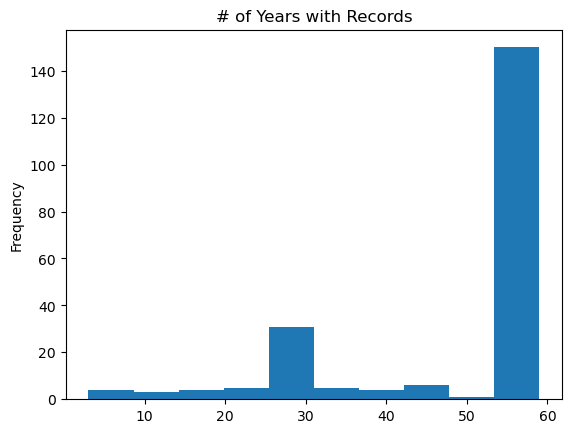

Data about tomatoes is available for 213 countries.


In [117]:
# Mostly complete records, but there are several countries with fewer records (and this is just one example crop)

veg_harvest = crops_long.loc[crops_long['Item'].isin(vegetables)]
veg_harvest.loc[veg_harvest['Item']=='Tomatoes'].groupby('Area').aggregate('count').sort_values('Value')['Value'].plot.hist()
plt.title("# of Years with Records")
plt.show()

print(f"Data about tomatoes is available for {len(veg_harvest.loc[veg_harvest['Item']=='Tomatoes'].groupby('Area').aggregate('count').index)} countries.")

## Individual country reports over time

In [118]:
def plot_crop(country, crop):
    veg_harvest.loc[(veg_harvest['Item']==crop) & (veg_harvest['Area'] == country),['Year','Value']].plot(x='Year',y='Value', legend=None)
    plt.title(f"Country: {country}, Crop: {crop}")
    plt.show()

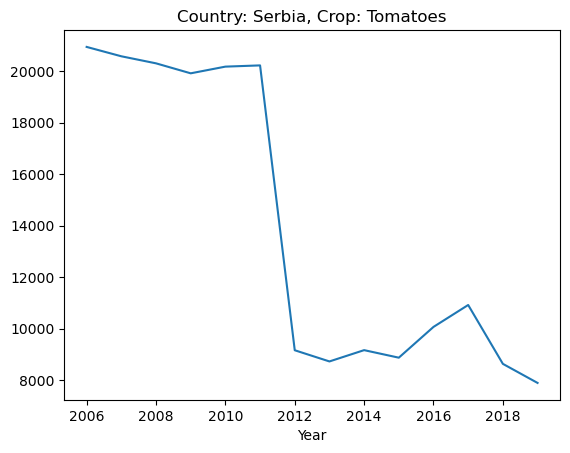

In [119]:
plot_crop("Serbia","Tomatoes")

In [ ]:
plot_crop("Sudan","Tomatoes")

In [ ]:
plot_crop("Israel","Tomatoes")

In [ ]:
plot_crop("China","Tomatoes")

## Function to create data input for model

In [ ]:
# Complete: 

## Final data format

## Select a crop or list of crops

## Calculate % of total area (mean of the most recent 'x' years)

# Pending

## Map country names to Pandemic shapefile

In [ ]:
def crop_percent(group_list, crop_list, years):
    # Can take either an individual crop group and crop, or a list
    # Crops can belong to multiple groups, so group of interest is needed
    # Years - recommend keeping 3 or 5 years of data

    # Error handling:

    # Type:

    # If group_list and crop_list are not lists, make lists
    if type(group_list) is not list:
        group_list = [group_list]
    if type(crop_list) is not list:
        crop_list = [crop_list]
    try: 
        years = int(years)
    except: 
        return print(f"Years should be a number (integer), e.g. 3. You provided '{years}'.")

    # Not correct items?

    # Is each group and crop in the FAO list?
    for i in group_list:
        if i not in crop_groups['Item Group'].unique():
            print(f"{i} is not in the FAO Crop Groups. Did you mean something else? \nProcessing anyway!")

    for i in crop_list:
        if i not in crops['Item'].unique():
            print(f"{i} is not in the FAO Crops. Did you mean something else? \nProcessing anyway!")

    # Filter and create dataframe
    items_in_groups = crop_groups.loc[crop_groups['Item Group'].isin(group_list),"Item"].values
    area_items_df = crops_long.loc[crops_long['Item'].isin(items_in_groups)]
    years_area_df = area_items_df[["Item","Area","Year","Value"]].groupby(["Item","Area"]).apply(lambda dft: dft.nlargest(years, 'Year')).reset_index(drop=True)
    mean_area_df = years_area_df.groupby(["Item","Area"])['Value'].agg("mean").reset_index()
    total_area = mean_area_df.groupby('Area').sum('Value').rename(columns={"Value":"Group Area"}).reset_index()
    crops_area = mean_area_df.loc[mean_area_df['Item'].isin(crop_list)].groupby('Area').sum('Value').rename(columns={"Value":"Crop Area"}).reset_index()
    per_area_df = pd.merge(total_area, crops_area, on="Area")
    per_area_df['Percent Area'] = per_area_df['Crop Area']/per_area_df['Group Area']

    return per_area_df

In [ ]:
# Test results

crop_percent(["Vegetables Primary","blip"],["Tomatoes","Peppers","Pepper (piper spp.)"],4)

In [ ]:
crop_percent("Vegetables Primary","Tomatoes","three")

In [ ]:
crop_percent("Vegetables Primary","Tomatoes",3)